# qrt data challenge 2023

## libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## loading the data

- `x_train` and `x_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `x_train` and `y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 


In [2]:
# After downloading the x_train/x_test/y_train .csv files in your working directory:
x_train_raw = pd.read_csv('x_train.csv')
x_test_raw = pd.read_csv('x_test.csv')
y_train_raw = pd.read_csv('y_train.csv')

x_train_original = pd.read_csv('x_train.csv')
y_train_original = pd.read_csv('y_train.csv')
x_test_original = pd.read_csv('x_test.csv')

x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')

In [3]:
x_train_original.shape

(1494, 35)

In [4]:
x_train.shape

(1494, 35)

In [5]:
x_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [6]:
y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


In [7]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)

x_train shape: (1494, 35)
x_test shape: (654, 35)
y_train shape: (1494, 2)


In [8]:
print('column headers:', x_train.columns.values)

column headers: ['ID' 'DAY_ID' 'COUNTRY' 'DE_CONSUMPTION' 'FR_CONSUMPTION'
 'DE_FR_EXCHANGE' 'FR_DE_EXCHANGE' 'DE_NET_EXPORT' 'FR_NET_EXPORT'
 'DE_NET_IMPORT' 'FR_NET_IMPORT' 'DE_GAS' 'FR_GAS' 'DE_COAL' 'FR_COAL'
 'DE_HYDRO' 'FR_HYDRO' 'DE_NUCLEAR' 'FR_NUCLEAR' 'DE_SOLAR' 'FR_SOLAR'
 'DE_WINDPOW' 'FR_WINDPOW' 'DE_LIGNITE' 'DE_RESIDUAL_LOAD'
 'FR_RESIDUAL_LOAD' 'DE_RAIN' 'FR_RAIN' 'DE_WIND' 'FR_WIND' 'DE_TEMP'
 'FR_TEMP' 'GAS_RET' 'COAL_RET' 'CARBON_RET']


## preprocessing and cleaning dataset

In [9]:
# sort x_train by day, rather than index
x_train.sort_values(by=['DAY_ID'], inplace=True)
x_test.sort_values(by=['DAY_ID'], inplace=True)
x_train.head(10)

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
742,1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,...,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003
1211,1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047
1408,1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
1468,111,2,DE,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
329,2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
680,800,3,DE,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
512,2047,5,FR,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,-0.552878,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870
991,831,5,DE,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,-0.552878,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870
592,1995,7,FR,0.057599,-0.625625,0.002239,-0.002239,-0.676226,-0.745182,0.676226,...,-0.806379,-0.531862,-0.663419,0.098940,1.367421,-0.812164,0.954384,-0.379980,0.518459,-0.034642
1356,779,7,DE,0.057599,-0.625625,0.002239,-0.002239,-0.676226,-0.745182,0.676226,...,-0.806379,-0.531862,-0.663419,0.098940,1.367421,-0.812164,0.954384,-0.379980,0.518459,-0.034642


In [10]:
x_test.head(10)

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
446,1626,4,FR,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
231,410,4,DE,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
120,1778,6,FR,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
570,562,6,DE,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
491,1966,9,FR,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597
199,750,9,DE,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597
17,1125,10,FR,0.306463,0.801805,0.344529,-0.344529,0.902401,-0.367998,-0.902401,...,0.781131,0.228760,0.778244,-0.099916,-0.310299,-0.408420,-1.394075,-1.201562,0.570510,-0.210186
202,802,13,DE,-0.138870,-0.702079,-0.521880,0.521880,-1.067974,-0.670168,1.067974,...,-0.782514,0.410745,-0.139418,0.573454,0.498127,-0.571953,-0.349293,-0.548502,0.578269,-0.831399
521,2018,13,FR,-0.138870,-0.702079,-0.521880,0.521880,-1.067974,-0.670168,1.067974,...,-0.782514,0.410745,-0.139418,0.573454,0.498127,-0.571953,-0.349293,-0.548502,0.578269,-0.831399
512,1087,17,FR,0.209703,-0.814539,0.439779,-0.439779,NaN,-0.045395,NaN,...,-0.859335,1.470660,-0.078553,-0.382155,-0.169914,0.010169,-0.542401,1.074063,0.770298,0.598617


### null values

In [11]:
# country to 0 and 1's
x_train["COUNTRY"] = x_train["COUNTRY"].map({'FR':0, 'DE':1})
x_test["COUNTRY"] = x_test["COUNTRY"].map({'FR':0, 'DE':1})

In [12]:
x_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
742,1057,0,0,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,...,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003
1211,1179,1,0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047
1408,1327,2,0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
1468,111,2,1,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
329,2016,3,0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756


In [13]:
x_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
446,1626,4,0,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
231,410,4,1,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
120,1778,6,0,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
570,562,6,1,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
491,1966,9,0,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597


In [14]:
# dropping country column
x_train.drop(["COUNTRY"], axis=1, inplace=True)
x_test.drop(["COUNTRY"], axis=1, inplace=True)

In [15]:
# check for null values
missing_values=x_train.isnull().sum()
print(missing_values)

ID                    0
DAY_ID                0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64


In [16]:
# 124 / 851 = 14.5% rows have NaN / null values DE export/import column
# 70 / 851 = 8.2% rows have NaN / null values in FR export/import column
# 25 / 851 = 2.9% rows have NaN / null values in exchange column
# when columns dropped, 20% of total set removed. how can we keep this?
# fill nan with 0 -> ~27% (benchmark)

In [17]:
print('x_train shape:', x_train.shape)

x_train shape: (1494, 34)


In [18]:
# order ID, reset index
x_train.sort_values(by=['ID'], inplace=True)
x_train.reset_index(drop=True, inplace=True)
x_train.head(10)

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0,1190,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,2,38,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,3,872,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,4,933,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,5,750,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372
5,8,664,0.080585,-0.492467,-0.016194,0.016194,0.969847,0.373363,-0.969847,-0.373363,...,-0.415302,-0.158542,-0.028317,0.275206,-0.780026,0.903008,0.702167,0.000000,0.751743,-0.096038
6,9,821,0.223765,-0.370221,-1.487887,1.487887,-0.825025,1.120364,0.825025,-1.120364,...,-0.694784,-0.040480,0.006919,-0.039153,0.110820,1.730998,0.230202,-2.588255,-0.150019,-0.382642
7,10,365,0.263204,-0.218111,-1.224154,1.224154,-1.093566,0.947850,1.093566,-0.947850,...,-0.482298,-0.122068,-0.309827,-0.502343,-0.224969,1.273429,-0.419321,0.175473,-0.139109,0.745399
8,12,1092,0.320268,-0.107240,-1.106101,1.106101,-0.830674,0.783837,0.830674,-0.783837,...,-0.014458,0.301802,-0.663711,-0.276413,-0.694926,-1.045810,-0.780288,-0.302094,0.638991,0.192146
9,13,983,0.098021,-0.218004,-1.636719,1.636719,-1.125494,1.165670,1.125494,-1.165670,...,-0.192766,0.035651,-1.534553,-0.569997,-0.752995,-0.817408,-0.256620,0.303791,-0.106315,-0.236825


In [19]:
x_test.sort_values(by=['ID'], inplace=True)
x_test.reset_index(drop=True, inplace=True)
x_test.head(10)

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1,1072,0.599993,0.320804,0.141289,-0.141289,0.694028,0.074866,-0.694028,-0.074866,...,0.277952,-0.000759,-0.396363,-0.385935,-0.524933,-1.461775,-0.769528,-0.401694,0.718941,-2.161340
1,6,472,0.448365,0.057480,-0.378787,0.378787,0.972761,0.728716,-0.972761,-0.728716,...,0.038227,-0.281556,-0.273116,-0.328795,-0.543968,0.250721,-0.489679,1.393826,0.542969,0.844307
2,7,447,0.094138,-0.196407,-0.526749,0.526749,1.064523,0.867473,-1.064523,-0.867473,...,-0.324601,-0.357140,-0.173932,-0.353357,-0.517815,0.708057,0.739899,-1.472538,-0.659916,-1.668585
3,11,411,0.176210,-0.205967,-1.192766,1.192766,-1.878711,1.012265,1.878711,-1.012265,...,-0.289632,-0.391646,-0.533729,-0.210956,-0.492722,0.655087,-0.838305,0.743516,-1.637282,-0.391557
4,16,69,0.504677,0.159619,0.289817,-0.289817,0.013198,0.268416,-0.013198,-0.268416,...,0.182601,-0.352986,-0.341938,-0.410660,-0.787892,-1.862329,-2.474841,0.081457,0.165743,-0.566256
5,20,801,0.299293,-0.184248,-0.604111,0.604111,-0.099278,0.925315,0.099278,-0.925315,...,-0.105791,-0.016487,0.084582,-0.478231,-0.961603,-0.944793,-0.989323,-0.291083,-1.084724,-1.162785
6,22,433,0.384416,-0.352268,-1.908560,1.908560,-0.972738,1.324199,0.972738,-1.324199,...,-0.779286,-0.640040,-0.458347,-0.286129,-0.061060,-1.118711,-0.221393,0.720357,1.116199,0.059021
7,24,1157,0.615443,-0.393289,-1.461803,1.461803,-0.738683,1.220303,0.738683,-1.220303,...,-0.411849,1.063539,-0.208211,-0.766459,-0.635710,-0.919489,-0.570956,-1.303813,-0.502815,-1.249851
8,27,260,0.533618,-0.403144,-1.460151,1.460151,-0.897080,1.263958,0.897080,-1.263958,...,-0.378126,4.793389,-1.185989,-0.110839,-0.617308,-0.543146,-0.553724,0.826050,0.236454,-0.575114
9,29,502,0.304682,-0.535423,-1.443283,1.443283,-1.759806,1.410687,1.759806,-1.410687,...,-0.397988,-0.835453,-0.606312,-0.783469,-1.202406,-1.135417,-0.488929,-0.639782,-0.388311,-0.160817


### fill na values with mean

In [20]:
# filling NA values - more data the better
for col in x_train.columns:
#    x_train = x_train.apply(lambda col: col.fillna(col.median()))
#    x_test = x_test.apply(lambda col: col.fillna(col.median()))
    x_train[str(col)].fillna(x_train[str(col)].mean(), inplace=True)
    x_test[str(col)].fillna(x_test[str(col)].mean(), inplace=True)

### fill na values with 0

In [21]:
#x_test = x_test.fillna(0)
#x_train = x_train.fillna(0)
#x_train.head()
#x_test.head()

### drop na rows

In [22]:
#x_test = x_test.dropna(axis='rows')
#x_train = x_train.dropna(axis='rows')

In [23]:
np.where(pd.isnull(x_train))

(array([], dtype=int64), array([], dtype=int64))

### duplicates

In [24]:
# many days appears twice, two duplicated rows each but rest of data is same (minus country column)
# drop duplicates by day column
x_train.drop_duplicates(subset=['DAY_ID'], inplace=True)
x_test.drop_duplicates(subset=['DAY_ID'], inplace=True)

## match y_train to new x_train

In [25]:
y_train = y_train[y_train["ID"].isin(x_train["ID"])]
y_train.head()

,ID,TARGET
0,1054,0.028313
3,297,-0.260356
4,1101,-0.071733
7,1069,0.112850
11,819,-0.133381


In [26]:
# order by ID, reset index
y_train.sort_values(['ID'], inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_train.head()

,ID,TARGET
0,0,-0.163530
1,2,0.010774
2,3,-0.233505
3,4,0.029822
4,5,-0.073464


In [27]:
x_train.head(10)

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0,1190,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,2,38,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,3,872,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,4,933,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,5,750,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372
5,8,664,0.080585,-0.492467,-0.016194,0.016194,0.969847,0.373363,-0.969847,-0.373363,...,-0.415302,-0.158542,-0.028317,0.275206,-0.780026,0.903008,0.702167,0.000000,0.751743,-0.096038
6,9,821,0.223765,-0.370221,-1.487887,1.487887,-0.825025,1.120364,0.825025,-1.120364,...,-0.694784,-0.040480,0.006919,-0.039153,0.110820,1.730998,0.230202,-2.588255,-0.150019,-0.382642
7,10,365,0.263204,-0.218111,-1.224154,1.224154,-1.093566,0.947850,1.093566,-0.947850,...,-0.482298,-0.122068,-0.309827,-0.502343,-0.224969,1.273429,-0.419321,0.175473,-0.139109,0.745399
8,12,1092,0.320268,-0.107240,-1.106101,1.106101,-0.830674,0.783837,0.830674,-0.783837,...,-0.014458,0.301802,-0.663711,-0.276413,-0.694926,-1.045810,-0.780288,-0.302094,0.638991,0.192146
9,13,983,0.098021,-0.218004,-1.636719,1.636719,-1.125494,1.165670,1.125494,-1.165670,...,-0.192766,0.035651,-1.534553,-0.569997,-0.752995,-0.817408,-0.256620,0.303791,-0.106315,-0.236825


In [28]:
# drop ID column now
x_train.drop(["ID"], axis=1, inplace=True)
x_test.drop(["ID"], axis=1, inplace=True)
y_train.drop(["ID"], axis=1, inplace=True)

In [29]:
# day id now irrelevant as no repeated
x_train.drop(["DAY_ID"], axis=1, inplace=True)
x_test.drop(["DAY_ID"], axis=1, inplace=True)
x_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,0.637224,0.780458,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372


## model and train score

- different regression models ?
- test different columns dropped / not dropped
- different models for france and germany ?

In [30]:
x_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,0.637224,0.780458,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372


In [31]:
y_train = y_train['TARGET']

## testing different models

In [32]:
def metric_train(output, y):

    return spearmanr(output, y).correlation

In [33]:
# normalise inputs
#x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
#x_test = (x_test - x_test.mean(axis=0)) / x_test.std(axis=0)

In [34]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

In [35]:
# split training and testing set into batches
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.33)
                                                                            # random_state=10,  shuffle=False)

### simple linear regression

Spearman correlation for the training set using simple linear regression: 34.5%
Spearman correlation for the testing set using simple linear regression: 33.9%


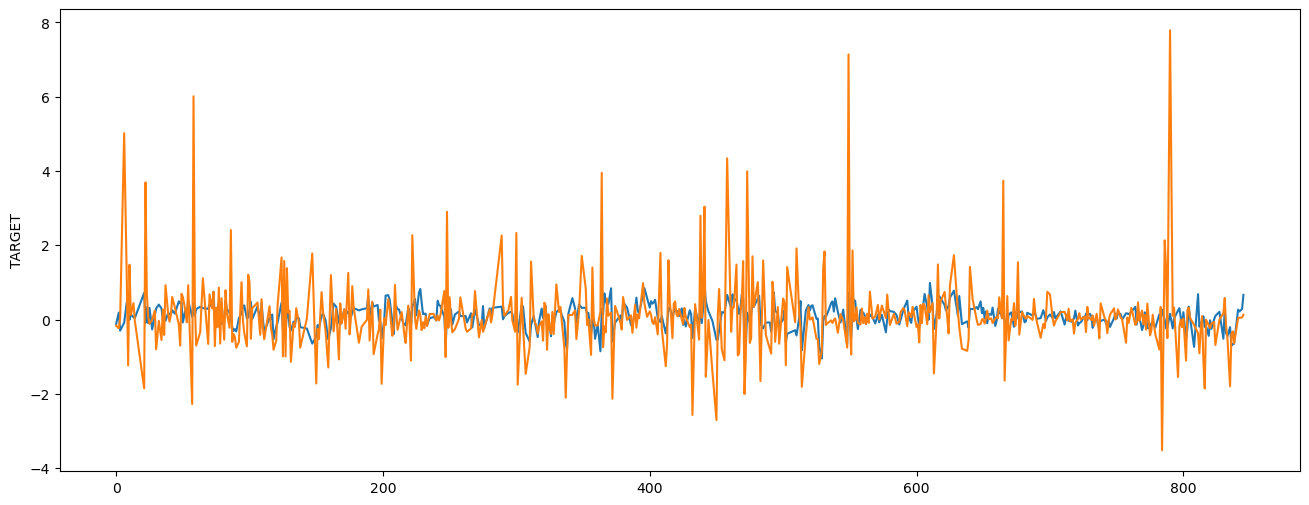

In [36]:
lr = LinearRegression()
lr.fit(x_train_split,y_train_split)

lr_output_train = lr.predict(x_train_split)
lr_output_test = lr.predict(x_test_split)

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=y_train_split.index, y=lr_output_train)
sns.lineplot(x=y_train_split.index, y=y_train_split)


print('Spearman correlation for the training set using simple linear regression: {:.1f}%'.format(100 * metric_train(lr_output_train, y_train_split) ))
print('Spearman correlation for the testing set using simple linear regression: {:.1f}%'.format(100 * metric_train(lr_output_test, y_test_split) ))

- mean fill na - 27.6%  <--- choose mean fill
- median fill na - 27.0% 
- not dropping day id - 26.6%

## generating the benchmark output

there definitely is a more efficient way of doing this, i recalled x_test/original/clean as the benchmark has 654 dimensions, the fully cleaned version (_test) has 365. 

i essentially redid prior steps so the shape of the submission was the same as the benchmark

In [43]:
x_train_original.shape

(1494, 35)

In [44]:
x_test_original.shape

(654, 35)

In [45]:
x_test.shape

(365, 32)

In [46]:
# dropping country column
x_train_original.drop(["COUNTRY"], axis=1, inplace=True)
x_test_original.drop(["COUNTRY"], axis=1, inplace=True)

In [47]:
for col in x_train_original.columns:
    x_train_original[str(col)].fillna(x_train_original[str(col)].mean(), inplace=True)
    x_test_original[str(col)].fillna(x_test_original[str(col)].mean(), inplace=True)

In [48]:
x_test_original.drop(["DAY_ID"], axis=1, inplace=True)
x_train_original.drop(["DAY_ID"], axis=1, inplace=True)

In [49]:
x_train_original.sort_values(by=['ID'], inplace=True)
x_test_original.sort_values(by=['ID'], inplace=True)
y_train_original.sort_values(by=['ID'], inplace=True)

In [50]:
x_train_original.drop(["ID"], axis=1, inplace=True)
x_test_original.drop(["ID"], axis=1, inplace=True)
y_train_original.drop(["ID"], axis=1, inplace=True)

In [51]:
y_train_original.head()

,TARGET
1365,-0.163530
1383,0.010774
306,-0.233505
344,0.029822
824,-0.073464


In [52]:
x_train_original.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
1365,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1383,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
306,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
344,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
824,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,0.637224,0.780458,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372


In [53]:
x_test_original.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
489,0.599993,0.320804,0.141289,-0.141289,0.694028,0.074866,-0.694028,-0.074866,0.959734,-0.144798,...,0.277952,-0.000759,-0.396363,-0.385935,-0.524933,-1.461775,-0.769528,-0.401694,0.718941,-2.161340
296,0.448365,0.057480,-0.378787,0.378787,0.972761,0.728716,-0.972761,-0.728716,0.787415,0.561132,...,0.038227,-0.281556,-0.273116,-0.328795,-0.543968,0.250721,-0.489679,1.393826,0.542969,0.844307
625,0.094138,-0.196407,-0.526749,0.526749,1.064523,0.867473,-1.064523,-0.867473,-0.028746,-0.191087,...,-0.324601,-0.357140,-0.173932,-0.353357,-0.517815,0.708057,0.739899,-1.472538,-0.659916,-1.668585
532,0.176210,-0.205967,-1.192766,1.192766,-1.878711,1.012265,1.878711,-1.012265,0.220693,-0.719768,...,-0.289632,-0.391646,-0.533729,-0.210956,-0.492722,0.655087,-0.838305,0.743516,-1.637282,-0.391557
430,0.504677,0.159619,0.289817,-0.289817,0.013198,0.268416,-0.013198,-0.268416,0.206821,0.098276,...,0.182601,-0.352986,-0.341938,-0.410660,-0.787892,-1.862329,-2.474841,0.081457,0.165743,-0.566256


### gradient boost

In [54]:
# Parameters for Gradient Boosting Regressor
optimal = {
    'n_estimators': 817,
    'max_depth': 27,
    'min_samples_split': 6,
    'learning_rate': 0.0002738880391289686}

# Gradient Boosting Regressor
reg = ensemble.GradientBoostingRegressor(**optimal)

# Fit the model
reg.fit(x_train_original, y_train_original)

gb_output_train_original = reg.predict(x_train_original)
gb_output_test_original = reg.predict(x_test_original)

print('Spearman correlation for original training set using gb regression: {:.1f}%'.format(100 * metric_train(gb_output_train_original, y_train_original) ))

Spearman correlation for original training set using gb regression: 70.3%


In [56]:
# Make the predictions

y_test_submission = pd.DataFrame(columns=['ID', 'TARGET'])

y_test_submission= x_test_raw[['ID']].copy()

y_test_submission['TARGET'] = gb_output_test_original

y_test_submission.to_csv('sharmin_qrt_submission.csv', index=False)

In [57]:
y_test_submission.shape

(654, 2)

In [58]:
y_test_submission.head()

,ID,TARGET
0,1115,0.017202
1,1202,0.026528
2,1194,0.064501
3,1084,0.021081
4,1135,0.111532


In [59]:
benchmark = pd.read_csv('y_test_random_final.csv')

In [60]:
benchmark.head()

,ID,TARGET
0,1115,-0.052395
1,1202,-0.112118
2,1194,1.050431
3,1084,-1.267154
4,1135,0.751565


In [61]:
benchmark.shape

(654, 2)

In [62]:
y_test_submission.shape

(654, 2)

In [63]:
''''
import optuna
# Set optuna verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train,test_size=0.33)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 500, 1500)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "learning_rate": learning_rate,
        "loss": "squared_error",
        }
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(x_train_split, y_train_split)
    prediction_y_test_split = reg.predict(x_test_split)

    return metric_train(prediction_y_test_split, y_test_split)*100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

study.best_params
'''

'\'\nimport optuna\n# Set optuna verbosity\noptuna.logging.set_verbosity(optuna.logging.WARNING)\n\nx_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train,test_size=0.33)\n\ndef objective(trial):\n    n_estimators = trial.suggest_int(\'n_estimators\', 500, 1500)\n    max_depth = trial.suggest_int(\'max_depth\', 10, 30)\n    min_samples_split = trial.suggest_int(\'min_samples_split\', 5, 10)\n    learning_rate = trial.suggest_float(\'learning_rate\', 0.0001, 0.01)\n\n    params = {\n        "n_estimators": n_estimators,\n        "max_depth": max_depth,\n        "min_samples_split": min_samples_split,\n        "learning_rate": learning_rate,\n        "loss": "squared_error",\n        }\n    \n    reg = ensemble.GradientBoostingRegressor(**params)\n    reg.fit(x_train_split, y_train_split)\n    prediction_y_test_split = reg.predict(x_test_split)\n\n    return metric_train(prediction_y_test_split, y_test_split)*100\n\nstudy = optuna.create_study(direct

## cross validate?

In [64]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

## neural network

In [65]:
# Split data into training and validation sets
#x_train_neuralnet, x_val_neuralnet, y_train_neuralnet, y_val_neuralnet = train_test_split(x_train.to_numpy(), y_train.to_numpy(), test_size=0.1, random_state=42)

### adam

In [66]:
opt = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

In [67]:
model_neuralnet_adam = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(32,)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)
])

In [68]:
'''
model_neuralnet_adam.compile(optimizer=opt, 
              loss='mse')

history_adam = model_neuralnet_adam.fit(
    x_train_neuralnet, 
    y_train_neuralnet,
    epochs=90,
    batch_size=31,
    validation_data=(x_val_neuralnet, y_val_neuralnet)
)
'''

"\nmodel_neuralnet_adam.compile(optimizer=opt, \n              loss='mse')\n\nhistory_adam = model_neuralnet_adam.fit(\n    x_train_neuralnet, \n    y_train_neuralnet,\n    epochs=90,\n    batch_size=31,\n    validation_data=(x_val_neuralnet, y_val_neuralnet)\n)\n"

In [69]:
''''
print(type(history_adam))
plt.plot(history_adam.history['loss'], label = 'adam')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Loss vs epoch")
plt.legend()
plt.show()
'''

'\'\nprint(type(history_adam))\nplt.plot(history_adam.history[\'loss\'], label = \'adam\')\nplt.xlabel("Epoch")\nplt.ylabel("MSE loss")\nplt.title("Loss vs epoch")\nplt.legend()\nplt.show()\n'

therefore will use adam optimiser

## tuning parameters

In [70]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [71]:
%%time
seed = 7,
numpy.random.seed(seed),
batch_size = 128,
epochs = 10

CPU times: user 93 µs, sys: 67 µs, total: 160 µs
Wall time: 144 µs


In [72]:
model_CV = KerasClassifier(build_fn=model_neuralnet_adam, epochs=epochs, 
                           batch_size=batch_size, verbose=1)

In [73]:
# define the grid search parameters
init_mode= ["n_estimators", "max_depth", "min_samples_split", "learning_rate", "loss"]

In [74]:
param_grid = dict(init_mode=init_mode)

In [75]:
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)

In [76]:
#grid_result = grid.fit(x_train, y_train)

In [77]:
# error with M1/M2 macs? 

how to fix overfitting